# Rotating neutron star example for O$_2$sclpy

For the underlying C++ code, see the O$_2$scl documentation at
https://awsteiner.org/code/o2scl/html. The Python wrapper,
O$_2$sclpy, is documentated at https://awsteiner.org/code/o2sclpy.
This rotating neutron star code is a Python wrapper to a C++ version
which was based on the original RNS code developed by Stergioulas
and Morsink. See
https://awsteiner.org/code/o2scl/html/class/nstar_rot.html.

Import necessary modules

In [2]:
import o2sclpy
import matplotlib.pyplot as plot
import numpy
import sys
from tqdm import trange, tqdm

In [3]:
plots=True
if 'pytest' in sys.modules:
    plots=False

Get a copy (a pointer to) the O$_2$scl unit conversion object, which
also allows access to the constant library

In [4]:
o2scl_settings=o2sclpy.lib_settings_class()
cu=o2scl_settings.get_convert_units()

## Rotating configuration with a tabulated EOS

Set up an EOS designed with the original RNS code (see
https://awsteiner.org/code/o2scl/html/class/eos_nstar_rot_C.html for the C++ documentation).

In [5]:
eC=o2sclpy.eos_nstar_rot_C()
eC.set(True)

Create the rotating neutron star object and set the EOS

In [6]:
nr=o2sclpy.nstar_rot()
nr.verbose=1
nr.set_eos(eC)

Compute a configuration with a fixed central energy density and
a fixed axis ratio

In [7]:
nr.fix_cent_eden_axis_rat(2.0e15,0.59)

Obtain the output as a table3d object. See
https://awsteiner.org/code/o2scl/html/class/table3d.html.

In [8]:
t3d=o2sclpy.table3d()
nr.output_table(t3d)

Output the slice names: ed, pr, h, vsq, rho, gamma, omega, alpha.
Each of these slices is a two-dimensional array of numbers.

In [9]:
for i in range(0,t3d.get_nslices()):
    print(i,t3d.get_slice_name(i))

0 b'ed'
1 b'pr'
2 b'h'
3 b'vsq'
4 b'rho'
5 b'gamma'
6 b'omega'
7 b'alpha'


Print out the gravitational mass

In [10]:
print('Mass: %7.6e' % (nr.Mass/nr.MSUN))

Mass: 2.131250e+00


The final pressure has noise in the region of spacetime occupied by the vacuum, but the pressure elsehwere varies by orders of magnitudes. We use use a cutoff at low pressures to remove the noise.

In [11]:
t3d.function_slice('if(pr>1.0e-12,log10(pr),-12.0)','log10_pr')

Plot the pressure in the internal coordinate system

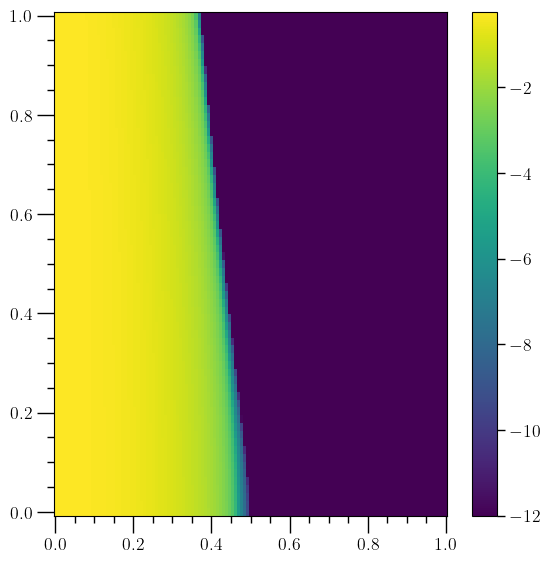

In [12]:
if plots:
    pb=o2sclpy.plot_base()
    pb.fig_dict='fig_size_x=6,fig_size_y=6,dpi=100'
    pb.colbar=True
    pb.den_plot([t3d,'log10_pr'])
    pb.show()
    plot.close()

Create a new table for the output in Cartesian coordinates

In [13]:
t3db=o2sclpy.table3d()
t3db.set_interp_type(o2sclpy.itp_linear)
rad_eq=nr.R_e/1.0e5
coord_grid=o2sclpy.uniform_grid_end.init(0.01,rad_eq*1.1,100)
t3db.set_xy_grid('x',coord_grid,'z',coord_grid)
t3db.line_of_names('ed pr')

Interpolate into Cartesian coordinates (to interpolate 10,000 points takes a minute):

In [14]:
for i in trange(t3db.get_nx()):
    for j in range(0,t3db.get_ny()):
        r=numpy.sqrt(coord_grid[i]**2+coord_grid[j]**2)
        theta=numpy.atan(-coord_grid[j]/coord_grid[i])+numpy.pi/2.0
        t3db.set(i,j,'ed',t3d.interp(r/(r+rad_eq),
                                     numpy.cos(theta),'ed'))
        t3db.set(i,j,'pr',t3d.interp(r/(r+rad_eq),
                                     numpy.cos(theta),'pr'))

100%|█████████████████████████████████████████| 101/101 [00:44<00:00,  2.25it/s]


Take the log carefully so we can plot

In [15]:
t3db.function_slice('if(pr>1.0e-5,log10(pr),-5.0)','log10_pr')

Plot the rotating neutron star, with the equator along the x-axis:

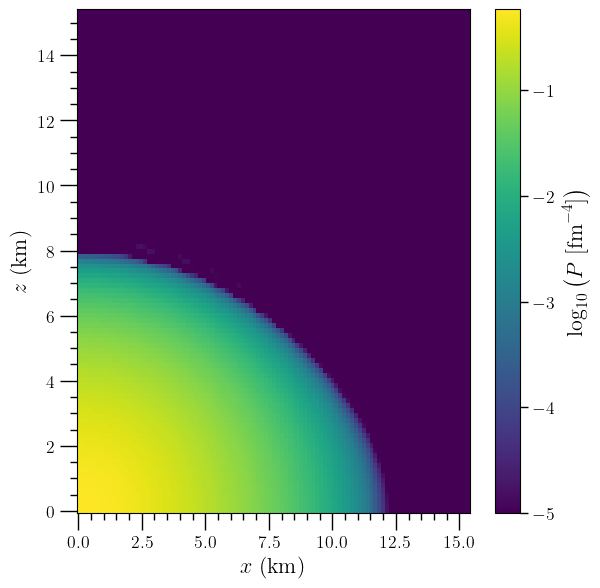

In [16]:
if plots:
    # Set canvas_flag=False to draw a new matplotlib canvas:
    pb.canvas_flag=False
    pb.den_plot([t3db,'log10_pr'])
    pb.xtitle(r'$ x~(\mathrm{km}) $')
    pb.ytitle(r'$ z~(\mathrm{km}) $')
    pb.ttext(1.27,0.5,r'$ \log_{10} \left( P~[\mathrm{fm}^{-4}] \right) $',rotation=90)
    pb.show()
    plot.close()

## A rotating neutron star with a more complex EOS

Set up the equation of state of neutron matter near the saturation density. We use the parameterization from Gandolfi et al. (2012) (https://doi.org/10.1103/PhysRevC.85.032801). The values ``a`` and ``b`` are in MeV. The saturation density, ``n0`` is in $ \mathrm{fm}^{-3} $. We begin by setting up the basic variables.

In [17]:
a=13
alpha=0.49
S=32
L=44
b=S-16-a
beta=(L-3*a*alpha)/b/3
n0=0.16

We compute the EOS from baryon densities of $0.08$ to $0.32~\mathrm{fm}^{-3}$. We store EOS in a O$_2$scl ``table_units`` object (see https://awsteiner.org/code/o2scl/html/class/table_units.html). Note we store energy densities and pressures in units of $\mathrm{fm}^{-4}$. 

In [18]:
tab=o2sclpy.table_units()
tab.line_of_names('nb ed pr')
tab.line_of_units('1/fm^3 1/fm^4 1/fm^4')
tab.set_nlines(25)
for i in range(0,25):
    nb=0.08+i*0.01
    tab.set('nb',i,nb)
    tab.set('ed',i,939.0/197.33*nb+(nb*a*(nb/n0)**alpha+
                                    nb*b*(nb/n0)**beta)/197.33)
    tab.set('pr',i,(n0*a*alpha*(nb/n0)**(1.0+alpha)+
                    n0*b*beta*(nb/n0)**(1.0+beta))/197.33)

Compute the energy density and pressure at the highest baryon density currently in the table.

In [19]:
ed32=tab.get('ed',tab.get_nlines()-1)
pr32=tab.get('pr',tab.get_nlines()-1)

Beginning at $n_B=0.32$, we create a polytrope, with an index of $0.8$. (See https://awsteiner.org/code/o2scl/html/class/eos_tov_polytrope.html.) The coefficient is fixed by ensuring that the energy density and pressure from the lower-density EOS are matched. We use this polytrope up to a transition density of $n_B=0.64~\mathrm{fm}^{-3}$.

In [20]:
n1=0.8
coeff1=pr32/ed32**(1.0+1.0/n1)
p1=o2sclpy.eos_tov_polytrope()
p1.set_coeff_index(coeff1,n1)
p1.set_baryon_density(0.32,ed32)
nbtrans=0.64

Loop over baryon densities and add the polytrope to the table object:

In [21]:
for i in range(1,33):
    nb=0.32+i*(nbtrans-0.32)/32
    tab.line_of_data([nb,p1.ed_from_nb(nb),p1.pr_from_nb(nb)])

Record the last energy density and pressure so we can add another polytrope:

In [22]:
edlast=tab.get('ed',tab.get_nlines()-1)
prlast=tab.get('pr',tab.get_nlines()-1)

Set up the polytrope:

In [23]:
n2=0.7
coeff2=prlast/edlast**(1.0+1.0/n2)
p2=o2sclpy.eos_tov_polytrope()
p2.set_coeff_index(coeff2,n2)
p2.set_baryon_density(nbtrans,edlast)

We extend this to a very large baryon density, $n_B=1.5~\mathrm{fm}^{-3}$:

In [24]:
for i in range(1,33):
    nb=nbtrans+i*(1.5-nbtrans)/32
    tab.line_of_data([nb,p2.ed_from_nb(nb),p2.pr_from_nb(nb)])

Plot the EOS, indicating the points where the different EOS parts connect.

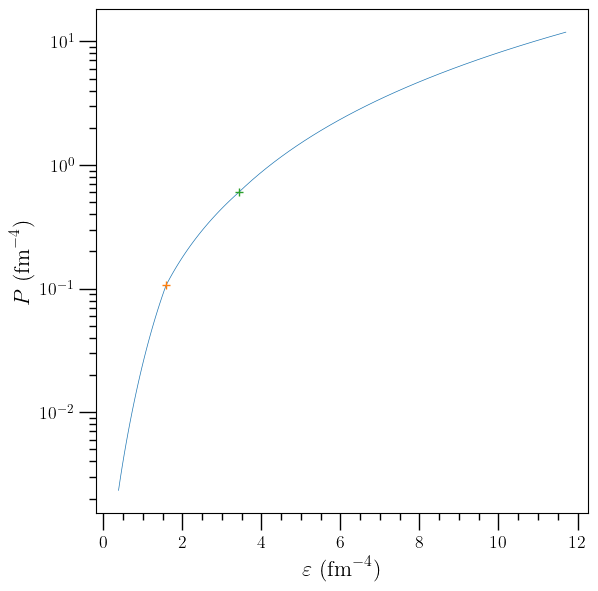

In [25]:
if plots:
    # Set canvas_flag=False to draw a new matplotlib canvas:
    pb.canvas_flag=False
    pb.colbar=False
    pb.logx=False
    pb.logy=True
    pb.plot([tab,'ed','pr'])
    pb.xtitle(r'$ \varepsilon~(\mathrm{fm}^{-4}) $')
    pb.ytitle(r'$ P~(\mathrm{fm}^{-4}) $')
    pb.point(ed32,pr32,marker='+')
    pb.point(edlast,prlast,marker='+')
    pb.show()
    plot.close()

Construct an EOS object for the TOV solver (see https://awsteiner.org/code/o2scl/html/class/eos_tov_interp.html). Add the default neutron star crust.

In [26]:
eti=o2sclpy.eos_tov_interp()
eti.default_low_dens_eos()
eti.read_table(tab,'ed','pr','nb')

In [28]:
ts=o2sclpy.tov_solve()
ts.set_eos(eti)
ts.verbose=1
ts.mvsr()

Mass versus radius mode.
Central P: 7.0000e-07 (Msun/km^3), M: 1.0686e-01 (Msun), R: 5.9523e+01 (km)
Central P: 7.7000e-07 (Msun/km^3), M: 1.1070e-01 (Msun), R: 4.9019e+01 (km)
Central P: 8.4700e-07 (Msun/km^3), M: 1.1499e-01 (Msun), R: 4.1684e+01 (km)
Central P: 9.3170e-07 (Msun/km^3), M: 1.1975e-01 (Msun), R: 3.6266e+01 (km)
Central P: 1.0249e-06 (Msun/km^3), M: 1.2497e-01 (Msun), R: 3.2147e+01 (km)
Central P: 1.1274e-06 (Msun/km^3), M: 1.3069e-01 (Msun), R: 2.8909e+01 (km)
Central P: 1.2401e-06 (Msun/km^3), M: 1.3692e-01 (Msun), R: 2.6321e+01 (km)
Central P: 1.3641e-06 (Msun/km^3), M: 1.4371e-01 (Msun), R: 2.4206e+01 (km)
Central P: 1.5005e-06 (Msun/km^3), M: 1.5107e-01 (Msun), R: 2.2460e+01 (km)
Central P: 1.6506e-06 (Msun/km^3), M: 1.5907e-01 (Msun), R: 2.0997e+01 (km)
Central P: 1.8156e-06 (Msun/km^3), M: 1.6773e-01 (Msun), R: 1.9763e+01 (km)
Central P: 1.9972e-06 (Msun/km^3), M: 1.7713e-01 (Msun), R: 1.8711e+01 (km)
Central P: 2.1969e-06 (Msun/km^3), M: 1.8727e-01 (Msun), R: 1.7

0

In [ ]:
Delete table rows larger than the maximum mass

In [27]:
nonrot=ts.get_results()
prmax=nonrot.get('pr',nonrot.lookup('gm',nonrot.max('gm')))
nonrot.delete_rows_func('pr>'+str(prmax))

Desc

In [28]:
edmax=nonrot.max('ed')
print('edmax',edmax,nonrot.get_unit('ed'))
edmax2=cu.convert('Msun/km^3','1/fm^4',edmax)
print('edmax2',edmax2,'1/fm^4')
tab.deriv_col('ed','pr','cs2')
cs2_max=0

edmax 0.0016363122285021168 b'Msun/km^3'
edmax2 9.249465315790495 1/fm^4


Desc

In [29]:
for i in range(0,tab.get_nlines()):
    print(i,tab.get('ed',i),edmax2,tab.get('cs2',i))
    if tab.get('ed',i)<edmax2 and tab.get('cs2',i)>cs2_max:
        cs2_max=tab.get('cs2',i)
print('cs2_max',cs2_max)

0 0.384613589977625 9.249465315790495 0.012494176897938018
1 0.4330185839599573 9.249465315790495 0.013985637274658139
2 0.4814998033113402 9.249465315790495 0.016811121846601794
3 0.5300624556310402 9.249465315790495 0.01978080985253972
4 0.5787126307167264 9.249465315790495 0.02325477280974863
5 0.6274572234749629 9.249465315790495 0.027174846701916496
6 0.6763038759895955 9.249465315790495 0.03159263373311714
7 0.7252609326297224 9.249465315790495 0.036528004641609525
8 0.7743374043480464 9.249465315790495 0.04200710343007176
9 0.8235429396515173 9.249465315790495 0.04805216986047157
10 0.872887800541321 9.249465315790495 0.05468426022240193
11 0.9223828422371005 9.249465315790495 0.06192249636320628
12 0.9720394958397978 9.249465315790495 0.069784218255791
13 1.0218697533163397 9.249465315790495 0.0782849541459594
14 1.0718861543474325 9.249465315790495 0.08743819161697494
15 1.1221017746912596 9.249465315790495 0.09725612176814875
16 1.1725302157961375 9.249465315790495 0.10774668

The radius of a 1.4 solar mass neutron star

In [30]:
rad14=nonrot.interp('gm',1.4,'r')
print('rad14 %7.6e' % (rad14))

rad14 1.182518e+01


Desc

In [31]:
enri=o2sclpy.eos_nstar_rot_interp()
edv=o2sclpy.std_vector()    
prv=o2sclpy.std_vector()    
nbv=o2sclpy.std_vector()

Desc

In [32]:
for i in range(0,tab.get_nlines()):
    edv.push_back(tab.get('ed',i))
    prv.push_back(tab.get('pr',i))
    nbv.push_back(tab.get('nb',i))
enri.set_eos_fm(tab.get_nlines(),edv,prv,nbv)

Construct a configuration with a specified central energy density
and axis ratio

In [33]:
nr=o2sclpy.nstar_rot()
nr.verbose=1
nr.set_eos(enri)
nr.fix_cent_eden_axis_rat(2.0e15,0.59)

In [34]:
print('Mass: %7.6e' % (nr.Mass/nr.MSUN))

Mass: 2.256231e+00
